We will start with a dataset of sensor data about hand gestures and, as a way of beginning our ML journey, we will learn a single model (in traditional fashion) from all the data to predict which hand gesture is depicted. Then we will implement Google's federated learning, as above, on this data. Then, there are a number of possible extensions to the work. One is to implement some new ideas that I have had for averaging the models. Another is to move to more challenging datasets from the domain of human activity recognition, which will need use of more complex neural networks for the learning.

do it for users

Reference need to be colleceted
Data needs to be 
maybe bad to have too much accuracy. hard to see if the federated approach makes a diff

===========================================================================
Questions for derek
Do convnets learn patterns from top left and apply it to the bottom right/
	The max pooling concept doesn’t follow that
Diff between rnn and residual connection

===========================================================================
Points to cover after basics

Secure aggregation
    the server doesnt know the key with which the data was encrypted

===========================================================================

Models to make
    traditional model learning from all data
    googles federated learning
        each user builds a model locally and shares the parameters that get learned. Centrally, the parameters are averaged and the averages are sent back to the users, who can incorporate them into the next round of local learning.


===========================================================================
dataset
    https://archive.ics.uci.edu/ml/datasets/MoCap+Hand+Postures


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras



from sklearn.model_selection import train_test_split

Each record is a set. The i-th marker of a given record does not necessarily correspond to the i-th marker of a different record. One may randomly permute the visible (not missing) markers of a given record without changing the set that the record represents. For the sake of convenience, all visible markers of a given record are given a lower index than any missing marker. A class is not guaranteed to have even a single record with all markers visible.

**Information on the Class enumeration**

Ranges from 1 to 5 with:
* 1 = Fist (with thumb out), 
* 2 = Stop (hand flat), 
* 3 = Point1 (point with pointer finger), 
* 4 = Point2 (point with pointer and middle fingers), 
* 5 = Grab (fingers curled as if to grab).

In [2]:
def draw_graphs(history_dict):
    # this is from the book 74,75
    # history = model.fit(...)
    # history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [3]:
def read_file(file):
    # read data
    df = pd.read_csv("dataset/allUsers.lcl.csv")

    # replace teh question marks with NaN and then change data type to float 32
    df.replace(["?"],np.nan, inplace = True)
    df = df.astype(np.float32)

    # imputation
    df.fillna(0,inplace=True) # fill nulls with 0

    return df 

df = read_file("dataset/allUsers.lcl.csv")
# shuffle the records
df_unshuffled = df
df = df.sample(frac=1) # shuffle data


In [4]:

def split_dataframe(df, user=None, val_ratio = 0.25, test_ratio =  0.75, seed = 1):
    # split into train, validation and test data using sklearn
    if user!=None:
        df = df[df["User"] == user]
    
    if df.shape[0] == 0:
        print(f"Dataframe for user {user} is of shape {df.shape}, no data. Skipping...")
        df = pd.DataFrame()
        return df, df, df, df, df, df, df, df, df
        
    df_train, df_test = train_test_split(df,
                                         test_size=test_ratio, 
                                         random_state = seed)

    df_train, df_val  = train_test_split(df_train, 
                                         test_size=val_ratio,
                                         random_state = seed)

    # store class and user information (in order)
    df_val_class, df_train_class, df_test_class = df_val["Class"], df_train["Class"], df_test["Class"]
    df_val_user,  df_train_user,  df_test_user  = df_val["User"],  df_train["User"],  df_test["User"]

    # drop the class and user identifier columns from data frame
    df_val   = df_val.  drop(df_train.columns[[0,1]], axis=1)
    df_train = df_train.drop(df_train.columns[[0,1]], axis=1)
    df_test  = df_test. drop(df_test. columns[[0,1]], axis=1)
    
    return df_val, df_val_class,  df_val_user, \
df_test, df_test_class, df_test_user, \
df_train, df_train_class, df_train_user

https://www.tensorflow.org/beta/tutorials/keras/basic_classification

In [18]:
def train_model(train_data, train_class,
          val_data, val_class, 
          epochs=32, verbose=0, return_weights = False, init_seed = 1):
    
    # same seed value for consistency sake, across all trainings too
    
    model = keras.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu',
                           kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(32, activation='relu',
                           kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(6, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_data, 
        train_class, 
        epochs = epochs,
        verbose = verbose,
        validation_data = (val_data, val_class)
    )

    if return_weights:
        return model, history, model.get_weights()
    return model, history


User 0 being trained on the model...


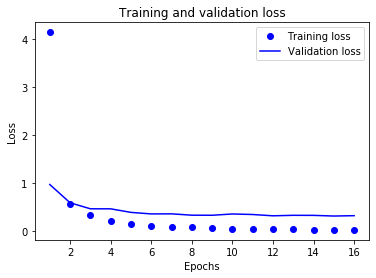

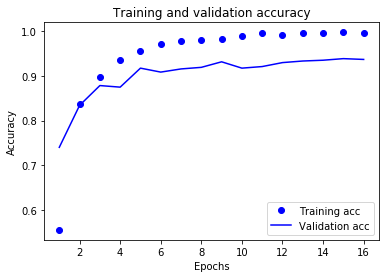

User 0 done!
User 0 being trained on the model...


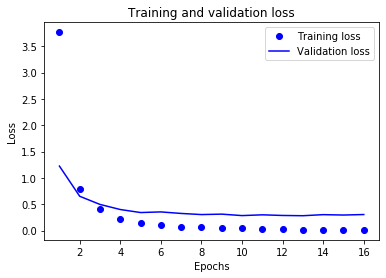

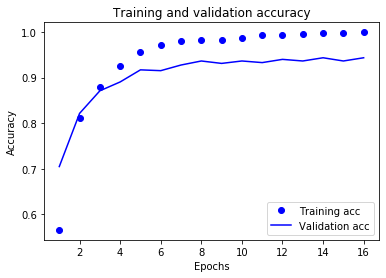

User 0 done!
User 0 being trained on the model...


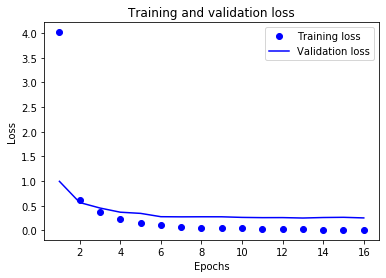

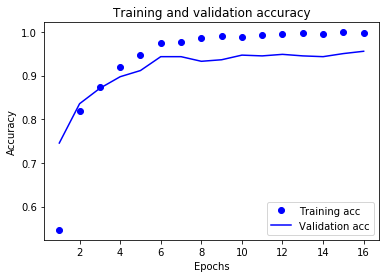

User 0 done!
User 0 being trained on the model...


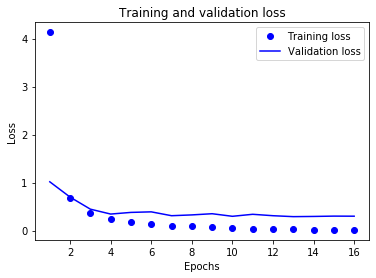

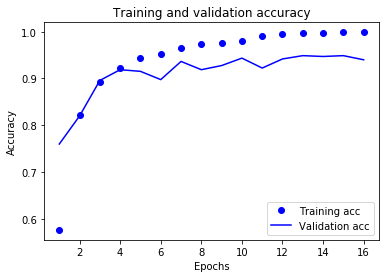

User 0 done!
User 0 being trained on the model...


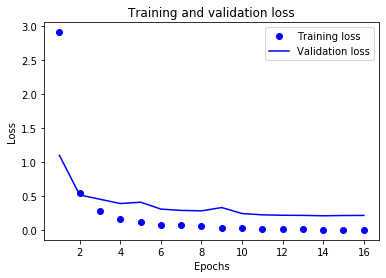

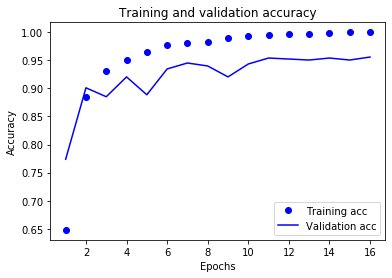

User 0 done!
User 0 being trained on the model...


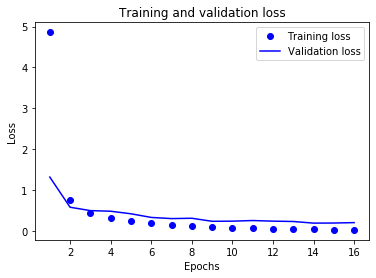

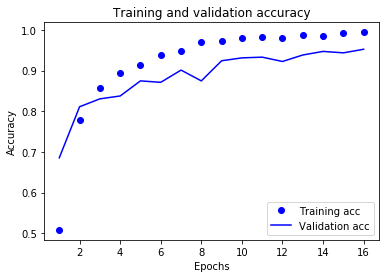

User 0 done!
User 0 being trained on the model...


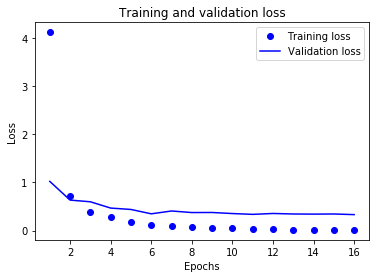

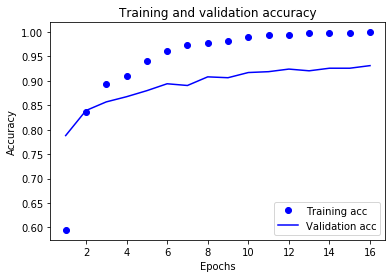

User 0 done!
User 0 being trained on the model...


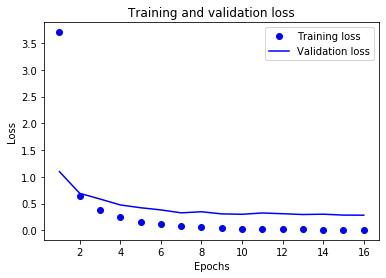

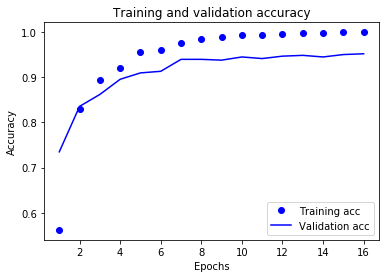

User 0 done!
User 0 being trained on the model...


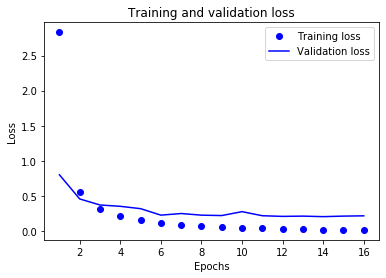

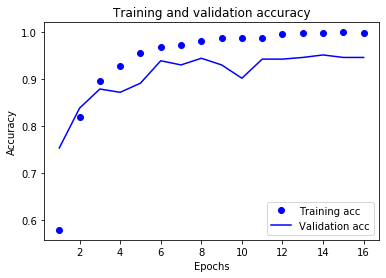

User 0 done!
User 0 being trained on the model...


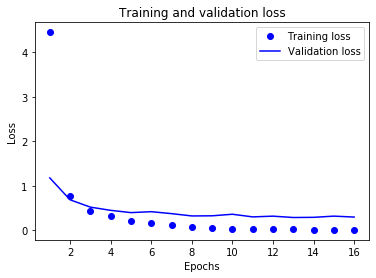

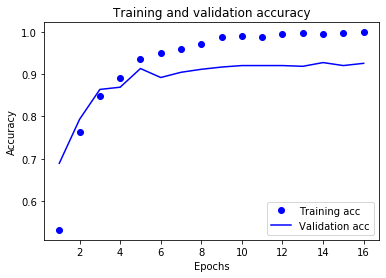

User 0 done!


In [20]:


weights = []
# for i in range(6):
   
for i in range(6):
    print(f"User {i} being trained on the model...")
    
    df_val, df_val_class,  df_val_user, df_test, df_test_class, df_test_user, df_train, df_train_class, df_train_user = split_dataframe(df,user=i)
    if df_val.shape[0]==0:
        continue
    
    model, history, weight = train_model(
        df_train.values, 
        df_train_class.values, 
        df_val.values, 
        df_val_class.values,
        epochs = 16,
        return_weights=True,
        init_seed=1
    )
   
    weights.append(weight)
    draw_graphs(history.history)
    print(f"User {i} done!")
    

In [21]:
w = weights [1]

# the weights are a list of numpy arrays from different layers of the model
n = 0
while True:
    try:
        print(f"{n} has {w[n].shape}")
        n+=1
    except:
        break

0 has (36, 128)
1 has (128,)
2 has (128, 32)
3 has (32,)
4 has (32, 6)
5 has (6,)


In [22]:
model.evaluate(df_test.values, df_test_class)

6787/6787 [==============================] - 1s 127us/sample - loss: 0.2911 - acc: 0.9409


[0.2910555278814048, 0.9409165]

In [9]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          multiple                  0         
_________________________________________________________________
dense_15 (Dense)             multiple                  4736      
_________________________________________________________________
dense_16 (Dense)             multiple                  4128      
_________________________________________________________________
dense_17 (Dense)             multiple                  198       
Total params: 9,062
Trainable params: 9,062
Non-trainable params: 0
_________________________________________________________________
